<a href="https://colab.research.google.com/github/vladi29/ANA-Classifier/blob/main/binary_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Universidad Simon Bolivar - 26 de Enero de 2022
# Trabajo final de grado: Clasificador de patrones ANA
# Vladimir Alfaro - 1510023

# Creacion, entrenamiento y prueba de una red para clasificacion binaria

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os
import time
import h5py

device = "cuda" if torch.cuda.is_available() else "cpu"

# Cleaning the VRAM memory
#torch.cuda.empty_cache()
#torch.cuda.reset_peak_memory_stats(device=None)
#print("Espacio disponible en GPU (Gb): ", torch.cuda.memory_allocated()*1e-9)

In [2]:
#----------Paths----------

images_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Augmented_dataset/'
original_labels_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/original_labels.csv'
original_names_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/original_names.csv'
augmented_labels_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/augmented_labels.csv'
augmented_names_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/augmented_names.csv'
original_ds_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/Original_dataset.h5'
augmented_ds_path =r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/Augmented_dataset.h5'

original_names = pd.read_csv(original_names_path, header = None)
original_names = original_names.values.tolist()

labels_raw = pd.read_csv(original_labels_path, header = None)
labels_raw = labels_raw.values.tolist()
original_labels = []
for label in labels_raw:
  original_labels.append(label[0])

augmented_names = pd.read_csv(augmented_names_path, header = None)
augmented_names = augmented_names.values.tolist()

labels_raw = pd.read_csv(augmented_labels_path, header = None)
labels_raw = labels_raw.values.tolist()
augmented_labels = []
for label in labels_raw:
  augmented_labels.append(label[0])

Negativos:  2905 
Positives:  7490


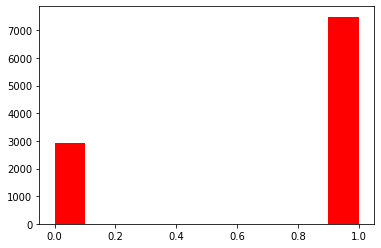

Muestras en el set de entrenamiento:  7276
Muestras en el set de validacion:  1559
Muestras en el set de pruebas:  1560


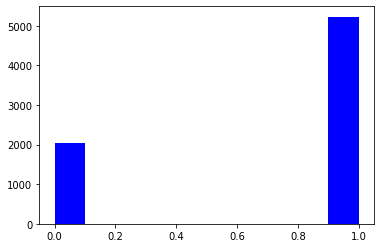

Negativos set de entrenamiento:  2048 
Positivos set de entrenamiento:  5228


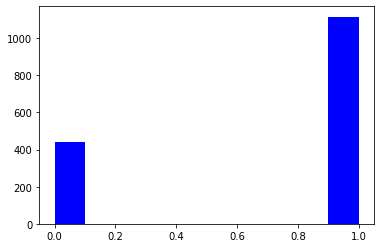

Negativos set de validacion:  443 
Positivos set de validacion:  1116


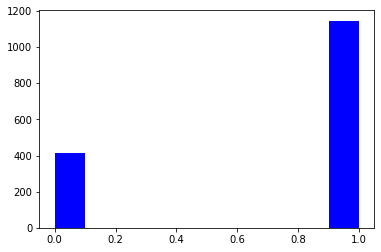

Negativos set de pruebas:  414 
Positivos set de pruebas:  1146


In [3]:
#Preparando la data para cambiar las clases por 1 para positivos y 0 para negativos

augmented_data = True
if(augmented_data):
  labels = augmented_labels
  names = augmented_names
else:
  labels = original_labels
  names = original_names

binary_labels = []
for label in labels:
  if label == 'Negative':
    binary_labels.append(0)
  else: 
    binary_labels.append(1)

Negatives = binary_labels.count(0)
Positives = binary_labels.count(1)
print("Negativos: ", Negatives, "\nPositives: ", Positives)
plt.hist(binary_labels, facecolor = 'red', alpha = 1)
plt.show()


#Division de la data para entrenar, validar y probar la red
x_train, x_val_test, y_train, y_val_test = train_test_split(names, binary_labels, test_size = 0.3, random_state=123)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.5, random_state=123)

print("Muestras en el set de entrenamiento: ", len(x_train))
print("Muestras en el set de validacion: ", len(x_val))
print("Muestras en el set de pruebas: ", len(x_test))

Train_negatives = y_train.count(0)
Train_positives = y_train.count(1)
plt.hist(y_train, facecolor = 'blue', alpha = 1)
plt.show()
print("Negativos set de entrenamiento: ", Train_negatives, "\nPositivos set de entrenamiento: ", Train_positives)

Val_negatives = y_val.count(0)
Val_positives = y_val.count(1)
plt.hist(y_val, facecolor = 'blue', alpha = 1)
plt.show()
print("Negativos set de validacion: ", Val_negatives, "\nPositivos set de validacion: ", Val_positives)

Test_negatives = y_test.count(0)
Test_positives = y_test.count(1)
plt.hist(y_test, facecolor = 'blue', alpha = 1)
plt.show()
print("Negativos set de pruebas: ", Test_negatives, "\nPositivos set de pruebas: ", Test_positives)

tensor([0])


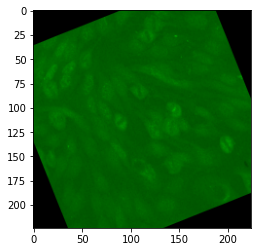

tensor([1])


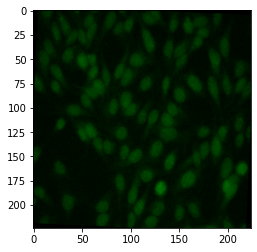

tensor([1])


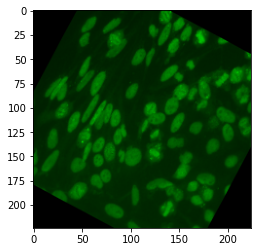

In [4]:
#Clase Dataset Personaliazdo

class CustomImageDataset(Dataset):
    def __init__(self, dataset, names, labels, transform=None):
        self.dataset = dataset
        self.names = names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_name = self.names[idx][0].split('.')[0]
        image = self.dataset.get(image_name)[:] 
        image = torch.tensor(image)  
        label = torch.tensor(self.labels[idx])
        label = torch.reshape(label, (1, ))  

        if self.transform:
            image = self.transform(image)
        
        return image, label

#Creando Dataloader para los conjuntos de entrenamiento y prueba

original_dataset = h5py.File(original_ds_path, 'r')
augmented_dataset = h5py.File(augmented_ds_path, 'r')

Batch_size = 64

train_data = CustomImageDataset(augmented_dataset, x_train, y_train) # transform=Custom_transform
train_dataloader = DataLoader(train_data, batch_size=Batch_size, shuffle=True, num_workers=2)   #-------------------------Cambiar el shuffle-----------------------

val_data = CustomImageDataset(augmented_dataset, x_val, y_val)
val_dataloader = DataLoader(val_data, batch_size=Batch_size, shuffle=True, num_workers=2)       #-------------------------Cambiar el shuffle----------------------- 

test_data = CustomImageDataset(augmented_dataset, x_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=Batch_size, shuffle=False, num_workers=2)    #-------------------------Cambiar el shuffle-----------------------

images, labels = next(iter(train_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

images, labels = next(iter(val_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

images, labels = next(iter(test_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

In [5]:
# Creacion de la InmunoNet

class InmunoNet(nn.Module):
  def __init__(self, numChannels, numClasses):
    super(InmunoNet, self).__init__()

    # Se inicializa la primera capa convolucional (CONV => RELU => POOL layers)
    self.conv1 = nn.Conv2d(in_channels = numChannels, out_channels = 10, kernel_size = (5, 5)) # 3 canales de entrada y 10 de salida
    self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # Se inicializa la segunda capa convolucional (CONV => RELU => POOL layers)
    self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = (5, 5)) # 10 canales de entrada y 20 de salida
    self.maxpool2 = nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))

    # Se inicializa la tercera capa convolucional (CONV => RELU => POOL layers)
    self.conv3 = nn.Conv2d(in_channels = 20, out_channels = 40, kernel_size = (4, 4)) # 20 canales de entrada y 40 de salida
    self.maxpool3 = nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))

    # initialize first set of FC => RELU layers
    self.fc1 = nn.Linear(in_features = 25000, out_features = 9000)

    # initialize second set of FC => RELU layers
    self.fc2 = nn.Linear(in_features = 9000, out_features = 4500)

    # initialize third set of FC => RELU layers
    self.fc3 = nn.Linear(in_features = 4500, out_features = 1000)

    # initialize fouth set of FC => RELU layers
    self.fc4 = nn.Linear(in_features = 1000, out_features = 500)

    # Final set of FC
    self.fcout = nn.Linear(in_features = 500, out_features = numClasses)
    
    # Activation functions
    self.relu = nn.ReLU()
    self.Softmax = nn.Softmax(dim=1)
    self.sigmoid = nn.Sigmoid()
    
    # Regularization
    self.dropout = nn.Dropout(0.5) # Dropout con 30% de porbabilidades de desactivar cada neuronar

  def forward(self, x):
    
    # Modificando el orden de los tensores (batch, canales, alto, ancho)
    x = x.permute(0, 3, 1, 2)

    # pass the input through our first set of CONV => RELU => POOL layers
    x = self.conv1(x)
    x = self.relu(x)
    x = self.maxpool1(x)

    # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
    x = self.conv2(x)
    x = self.relu(x)
    x = self.maxpool2(x)

    # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
    x = self.conv3(x)
    x = self.relu(x)
    x = self.maxpool3(x)
    
    # flatten the output from the previous layer and pass it through our first set of FC => RELU layers
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.relu(x)
    
    # pass the output from the previous layer through our second set of FC => RELU layers
    x = self.fc2(x)
    x = self.dropout(x)
    x = self.relu(x)

    # pass the output from the previous layer through our third set of FC => RELU layers
    x = self.fc3(x)
    x = self.dropout(x)
    x = self.relu(x)

    # pass the output from the previous layer through our third set of FC => RELU layers
    x = self.fc4(x)
    x = self.dropout(x)
    x = self.relu(x)

    # pass the output to our softmax classifier to get our output predictions
    x = self.fcout(x)
    output = self.sigmoid(x)
    #output = self.Softmax(x)
    
    # return the output predictions
    return output

In [6]:
# Clase para adaptar modelo pre-entrenados

class MyExtendedNet(nn.Module):
    def __init__(self, pretrained_model):
        super(MyExtendedNet, self).__init__()
        self.pretrained = pretrained_model
        self.new_layer = nn.Sequential(nn.Linear(1000, 1000),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(1000, 500),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(500, 100),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(100, 10),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(10, 1),
                                         nn.Sigmoid()
                                         )     
    
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.pretrained(x)
        x = self.new_layer(x)
        return x

In [7]:
# Funcion para el entrenamiento y validacion de la red

def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs, device):
  # Inicializamos dos arreglos para guardar el costo por epoca para el entrenamiento y la validacion
  training_cost, validation_cost = [], []

  for epoch in range(epochs):
    # Se inicializan la perdida del entrenamientos y de la validacion en 0
    training_batch_loss = []
    validation_batch_loss = []
    
    # Empieza el entrenamiento de la red
    model.train()
    Y_total = torch.ones((1,1)).to(device, torch.float32)      # Variable auxiliar para guardar todas las salidas
    Y_hat_total = torch.ones((1,1)).to(device, torch.float32)  # Variable auxiliar para guardar todas las salidas que predice el modelo
    for batch in iter(train_loader):
      X, Y = batch
      X = X.to(device, torch.float32)
      Y = Y.reshape((len(Y), 1))
      Y = Y.to(device, torch.float32)
      Y_hat = model(X)
      loss = loss_fn(Y_hat, Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      training_batch_loss.append(loss.data.item())
      Y_total = torch.cat((Y_total, Y), dim = 0)              # Concatenamos las salidas de cada lote
      Y_hat_total = torch.cat((Y_hat_total, Y_hat), dim = 0)  # Concatenamos las salidas que predice el modelo de cada lote
    training_cost_epoch = np.mean(training_batch_loss)
    training_cost.append(training_cost_epoch)
    Y_total = Y_total[1:]           # Retiramos el primer valor del tensor ya que es un 1
    Y_hat_total = Y_hat_total[1:]   # Retiramos el primer valor del tensor ya que es un 1
    Y_hat_total[Y_hat_total > 0.8] = 1
    Y_hat_total[Y_hat_total < 1] = 0
    if (device == torch.device('cuda:0')):
      training_epoch_acc = accuracy_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
      training_epoch_pre = precision_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
      training_epoch_recall = recall_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
      training_epoch_F1 = f1_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy()) 
    else:
      training_epoch_acc = accuracy_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
      training_epoch_pre = precision_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
      training_epoch_recall = recall_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
      training_epoch_F1 = f1_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
    print("Epoca: ", (epoch + 1), "/", epochs)
    print("Costo de entrenamiento ", round(training_cost_epoch, 5))

    # Empieza la validacion de la red
    model.eval()
    Y_total = torch.ones((1,1)).to(device, torch.float32)      # Variable auxiliar para guardar todas las salidas
    Y_hat_total = torch.ones((1,1)).to(device, torch.float32)  # Variable auxiliar para guardar todas las salidas que predice el modelo
    for batch in iter(val_loader):
      X, Y = batch
      X = X.to(device, torch.float32)
      Y = Y.reshape((len(Y), 1))
      Y = Y.to(device, torch.float32)
      Y_hat = model(X)
      loss = loss_fn(Y_hat, Y)
      validation_batch_loss.append(loss.data.item())
      Y_total = torch.cat((Y_total, Y), dim = 0)              # Concatenamos las salidas de cada lote
      Y_hat_total = torch.cat((Y_hat_total, Y_hat), dim = 0)  # Concatenamos las salidas que predice el modelo de cada lote
    validation_cost_epoch = np.mean(validation_batch_loss)
    validation_cost.append(validation_cost_epoch)
    Y_total = Y_total[1:]           # Retiramos el primer valor del tensor ya que es un 1
    Y_hat_total = Y_hat_total[1:]   # Retiramos el primer valor del tensor ya que es un 1
    Y_hat_total[Y_hat_total > 0.8] = 1
    Y_hat_total[Y_hat_total < 1] = 0
    if (device == torch.device('cuda:0')):
      validation_epoch_acc = accuracy_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
      validation_epoch_pre = precision_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
      validation_epoch_recall = recall_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
      validation_epoch_F1 = f1_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy()) 
    else:
      validation_epoch_acc = accuracy_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
      validation_epoch_pre = precision_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
      validation_epoch_recall = recall_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
      validation_epoch_F1 = f1_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
    print("Costo de validacion ", round(validation_cost_epoch, 5))
    print("Metricas del entrenmaiento:\n", "Exactitud: ", round(training_epoch_acc, 2), " Precision: ",
          round(training_epoch_pre, 2), " Recall: ", round(training_epoch_recall, 2), " F1: ", round(training_epoch_F1, 2))
    print("Metricas de la validacion:\n", "Exactitud: ", round(validation_epoch_acc, 2), " Precision: ",
          round(validation_epoch_pre, 2), " Recall: ", round(validation_epoch_recall, 2), " F1: ", round(validation_epoch_F1, 2), "\n")
  return training_cost, validation_cost   

  # Accuracy = TP + TN / (TP + TN + FP + FN)
  # Precision = TP / (TP + FP)
  # Recall = TP / (TP + FN) 
  # F1 = 2 * (Precision * Recall) / (Precision + Recall)

In [8]:
def train_model_2(model, optimizer, loss_fn, train_dataloader, val_dataloader, epochs, device):

    model.to(device)
    training_loss, validation_loss = [], []
    aux_acc = 0.9

    for epoch in range(0, epochs):
        model.train()
        train_loss, train_acc, train_prec, train_recall, train_f1 = [], [], [], [], []
        for batch in iter(train_dataloader):
            X, Y = batch
            X, Y = X.to(device, torch.float32), Y.to(device, torch.float32)
            optimizer.zero_grad()
            Y_hat = model(X)
            loss = loss_fn(Y_hat, Y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
            Y_hat[Y_hat > 0.5] = 1
            Y_hat[Y_hat < 1] = 0
            
            # Metricas
            # GPU
            if (device == torch.device('cuda:0')):
              acc = accuracy_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy())
              prec = precision_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average='weighted', zero_division=1)
              recall = recall_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average='weighted', zero_division=1)
              f1 = f1_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average='weighted', zero_division=0) 
            # CPU
            else:
              acc = accuracy_score(Y.detach().numpy(), Y_hat.detach().numpy())
              prec = precision_score(Y.detach().numpy(), Y_hat.detach().numpy(), average='weighted', zero_division=1)
              recall = recall_score(Y.detach().numpy(), Y_hat.detach().numpy(), average='weighted', zero_division=1)
              f1 = f1_score(Y.detach().numpy(), Y_hat.detach().numpy(), average='weighted', zero_division=0)
            
            train_acc.append(acc)
            train_prec.append(prec) 
            train_recall.append(recall)
            train_f1.append(f1)
        
        model.eval()
        val_loss, val_acc, val_prec, val_recall, val_f1 = [], [], [], [], []
        with torch.no_grad():
            for batch in iter(val_dataloader):
                X, Y = batch
                X, Y = X.to(device, torch.float32), Y.to(device, torch.float32)
                Y_hat = model(X)
                loss = loss_fn(Y_hat, Y)
                val_loss.append(loss.item())
                
                Y_hat[Y_hat > 0.5] = 1
                Y_hat[Y_hat < 1] = 0

                # Metricas
                # GPU
                if (device == torch.device('cuda:0')):
                  acc = accuracy_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy())
                  prec = precision_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average='weighted', zero_division=1)
                  recall = recall_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average='weighted', zero_division=1)
                  f1 = f1_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average='weighted', zero_division=0) 
                # CPU
                else:
                  acc = accuracy_score(Y.detach().numpy(), Y_hat.detach().numpy())
                  prec = precision_score(Y.detach().numpy(), Y_hat.detach().numpy(), average='weighted', zero_division=1)
                  recall = recall_score(Y.detach().numpy(), Y_hat.detach().numpy(), average='weighted', zero_division=1)
                  f1 = f1_score(Y.detach().numpy(), Y_hat.detach().numpy(), average='weighted', zero_division=0)
                
                val_acc.append(acc)
                val_prec.append(prec) 
                val_recall.append(recall)
                val_f1.append(f1)
        
        print(f"Epoca:{epoch + 1}/{epochs} \n")
        print(f"train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f} \n")
        print(f"train acc: {np.mean(train_acc):.5f}, val acc: {np.mean(val_acc):.5f} \n")
        print(f"train prec: {np.mean(train_prec):.5f}, val prec: {np.mean(val_prec):.5f} \n")
        print(f"train recall: {np.mean(train_recall):.5f}, val recall: {np.mean(val_recall):.5f} \n")
        print(f"train f1: {np.mean(train_f1):.5f}, val f1: {np.mean(val_f1):.5f} \n")

        if(np.mean(val_acc) > aux_acc):
          torch.save(model.state_dict(), 'drive/MyDrive/Colab_Notebooks/Tesis/Models/Binary_model.pt')
          aux_acc = np.mean(aux_acc)
          print("Modelo guardado con Accuracy = ", aux_acc, "\n")

        training_loss.append(np.mean(train_loss))
        validation_loss.append(np.mean(val_loss))
         
    return training_loss, validation_loss

In [9]:
def test_model(model, test_loader, device):
  model.eval()
  Y_total = torch.ones((1,1)).to(device, torch.float32)      # Variable auxiliar para guardar todas las salidas
  Y_hat_total = torch.ones((1,1)).to(device, torch.float32)  # Variable auxiliar para guardar todas las salidas que predice el modelo
  for batch in iter(test_loader):
    X, Y = batch
    X = X.to(device, torch.float32)
    Y = Y.reshape((len(Y), 1))
    Y = Y.to(device, torch.float32)
    Y_hat = model(X)
    Y_total = torch.cat((Y_total, Y), dim = 0)               # Concatenamos las salidas de cada lote
    Y_hat_total = torch.cat((Y_hat_total, Y_hat), dim = 0)   # Concatenamos las salidas que predice el modelo de cada lote
  Y_total = Y_total[1:]           # Retiramos el primer valor del tensor ya que es un 1
  Y_hat_total = Y_hat_total[1:]   # Retiramos el primer valor del tensor ya que es un 1
  Y_hat_total[Y_hat_total > 0.8] = 1
  Y_hat_total[Y_hat_total < 1] = 0
  if (device == torch.device('cuda:0')):
    test_acc = accuracy_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
    test_pre = precision_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
    test_recall = recall_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
    test_F1 = f1_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy()) 
    test_confusion_matrix = confusion_matrix(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy()) 
  else:
    test_acc = accuracy_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
    test_pre = precision_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
    test_recall = recall_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
    test_F1 = f1_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
    test_confusion_matrix = confusion_matrix(Y_total.detach().numpy(), Y_hat_total.detach().numpy())

  return test_acc, test_pre, test_recall, test_F1, test_confusion_matrix


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

Epoca:1/25 

train loss: 0.35090, val loss: 0.24361 

train acc: 0.84817, val acc: 0.89291 

train prec: 0.86876, val prec: 0.89369 

train recall: 0.84817, val recall: 0.89291 

train f1: 0.82503, val f1: 0.89077 

Epoca:2/25 

train loss: 0.25497, val loss: 0.26563 

train acc: 0.89765, val acc: 0.87777 

train prec: 0.90341, val prec: 0.90362 

train recall: 0.89765, val recall: 0.87777 

train f1: 0.89526, val f1: 0.88284 

Epoca:3/25 

train loss: 0.21687, val loss: 0.24793 

train acc: 0.91471, val acc: 0.88679 

train prec: 0.92122, val prec: 0.89300 

train recall: 0.91471, val recall: 0.88679 

train f1: 0.91367, val f1: 0.87973 

Epoca:4/25 

train loss: 0.20185, val loss: 0.20797 

train acc: 0.92725, val acc: 0.90389 

train prec: 0.93326, val prec: 0.90686 

train recall: 0.92725, val recall: 0.90389 

train f1: 0.92718, val f1: 0.90052 

Epoca:5/25 

train loss: 0.16859, val loss: 0.19090 

train acc: 0.93890, val acc: 0.92201 

train prec: 0.94239, val prec: 0.92342 

tr

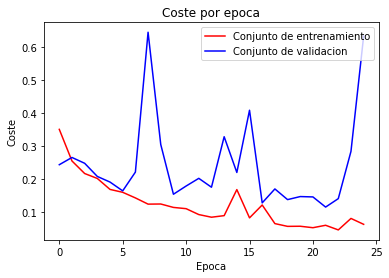

In [10]:
import torchvision.models as models

# Creacion del modelo

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

densenet201 = models.densenet201(pretrained=True)
binary_model = MyExtendedNet(densenet201)

#binary_model = InmunoNet(3, 1)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(binary_model.parameters(), lr = 0.001)
epochs = 25
if torch.cuda.is_available():
    binary_model.cuda()

# Entrenamiento y validacion

start_time = time.time()
training_cost, validation_cost = train_model_2(
    binary_model,
    optimizer,
    loss_fn, 
    train_dataloader, 
    val_dataloader,  
    epochs,
    device)
final_time = time.time() - start_time

print("Estructura del modelo: \n", binary_model, "\n")
print('Tiempo de entrenamiento:', round(final_time/60, 3), "\n")
plt.plot(range(epochs), training_cost, color = "r", label = "Conjunto de entrenamiento")
plt.plot(range(epochs), validation_cost, color = "b", label = "Conjunto de validacion")
plt.title("Coste por epoca")
plt.xlabel("Epoca")
plt.ylabel("Coste")
plt.legend()
plt.show()

In [11]:
# Prueba del modelo

start_time = time.time()
test_acc, test_pre, test_recall, test_F1, test_conf_mat = test_model(
    binary_model, 
    test_dataloader, 
    device)
final_time = time.time() - start_time
print('Tiempo de test:', round(final_time/60, 3), "\n")
print("Metricas del test:\n", "Exactitud: ", round(test_acc, 2), " Precision: ",
      round(test_pre, 2), " Recall: ", round(test_recall, 2), " F1: ", round(test_F1, 2), 
      "\n Matriz de Confusion: \n", test_conf_mat)

RuntimeError: ignored